# Demo of Earthquake Detection at Cook Inlet

Author: Qibin Shi

Tech support: Yiyu Ni

In [1]:
import sys
sys.path.append('../src/denoiser/')

import gc
import glob
import pygmt
import numpy as np
import pandas as pd

import torch
import seisbench.models as sbm
from ELEP.elep.ensemble_coherence import ensemble_semblance
from ELEP.elep.trigger_func import picks_summary_simple

from collections import Counter
from functools import reduce
from datetime import datetime
from das_util import try_gpu
from joblib import Parallel, delayed
from scipy import signal


import obspy
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn.client import Client

import pyocto

import matplotlib
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 22

filepath = '/fd1/QibinShi_data/akdas/qibin_data/elep_pyocto/coast_only/'

/home/qibins/anaconda3/envs/denoise/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/qibins/anaconda3/envs/denoise/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Availability of Coastal Stations

In [ ]:
client = Client("IRIS")
t1 = UTCDateTime("2023-12-01")
t2 = UTCDateTime("2023-12-31")

inventory = client.get_stations(network="AK,AV", channel="BH?",
                                starttime=t1, endtime=t2, 
                                maxlatitude=60.1809, minlatitude=58.5911, 
                                maxlongitude=-150.6555, minlongitude=-153.7177)

inventory

## 2. Detect Earthquakes on Stations


In [ ]:
### Functions to pick many windows
def apply_elep(data, list_models, paras_semblance, device):
    """
    Input: data of 1 station, 3 components, many time windows
           several eqT models (already to device and eval mode)
    Output: semblance for P or S
    """

    ### Normalize data
    tmp = data - np.mean(data, axis=-1, keepdims= True)
    mmax = np.max(np.abs(tmp), axis=-1, keepdims=True)
    data_max = np.divide(tmp , mmax, out=np.zeros_like(tmp), where=(mmax!=0))
    data_tt = torch.from_numpy(data_max).to(device, dtype=torch.float32)
    
    ### ELEP workflow
    twin = 6000  ## constant for EQTransformer
    nwin = data.shape[0]
   
    # predictions from all models
    batch_pred_P = np.zeros((len(list_models),nwin,twin)) 
    batch_pred_S = np.zeros((len(list_models),nwin,twin))
    smb = np.zeros((nwin,2,twin), dtype = np.float32)
    
    for ii, imodel in enumerate(list_models):
        with torch.no_grad():
            batch_pred_P[ii, :, :] = imodel(data_tt)[1].cpu().numpy()[:, :]
            batch_pred_S[ii, :, :] = imodel(data_tt)[2].cpu().numpy()[:, :]
    
    # semblance of all predictions
    smb[:,0,:] =np.array(Parallel(n_jobs=100)(delayed(ensemble_semblance)(batch_pred_P[:, iwin, :], paras_semblance) 
                                                    for iwin in range(nwin)))
    smb[:,1,:] =np.array(Parallel(n_jobs=100)(delayed(ensemble_semblance)(batch_pred_S[:, iwin, :], paras_semblance) 
                                                    for iwin in range(nwin)))
    
    del batch_pred_P, batch_pred_S, data_tt, data_max, mmax, tmp
    gc.collect()
    torch.cuda.empty_cache()
    
    return smb


def detect_on_fly(network, station, t1, filepath, width, stride, list_models, devcc):
    '''
    The workflow: 
    1) download data for 1 station
    2) window the data with stride
    3) apply ELEP
    4) save picks
    '''
   ########################
   ### Download waveforms
    try:
        sdata = client.get_waveforms(network=network, 
                                     station=station,
                                     location="*", 
                                     channel="BH?", 
                                     starttime=t1,
                                     endtime=t1 + 86400)
        
    except obspy.clients.fdsn.header.FDSNNoDataException:
        print(f"--- No data for {network}.{station} on {t1} ---")
        return
    
    fs_all = [tr.stats.sampling_rate for tr in sdata]
    fs = np.round(fs_all[0])
    if len(np.unique(np.array(fs_all))) > 1:      
        print(f"--- Sampling rates are different for {network}.{station} on {t1} ---")
        sdata = sdata.resample(fs)
    
    sdata.merge(fill_value='interpolate')  # fill gaps
    sdata.filter(type='bandpass',freqmin=0.5,freqmax=12)
    btime = sdata[0].stats.starttime
    

    # align 3 components
    max_b = max([tr.stats.starttime for tr in sdata])
    min_e = min([tr.stats.endtime for tr in sdata])
    for tr in sdata:
        tr.trim(starttime=max_b, endtime=min_e, nearest_sample=True)    
        
    ########################
    ### Window data
    arr_sdata = np.array(sdata)
    if len(arr_sdata.shape) == 1:
        arr_sdata = arr_sdata[np.newaxis, :] # add dimension
    if arr_sdata.shape[0] == 1:
        arr_sdata = np.repeat(arr_sdata, 3, axis=0)
    elif arr_sdata.shape[0] == 2:
        arr_sdata = np.vstack((arr_sdata, arr_sdata[1]))
    elif arr_sdata.shape[0] > 3:
        arr_sdata = arr_sdata[:3]

    nwin = (arr_sdata.shape[1] - width) // stride
    if nwin < 1: 
        print(f"--- Data too short for {network}.{station} on {t1} ---")
        return
    arr_sdata = arr_sdata[:, :int(nwin * stride + width)]
    
    win_idx = np.zeros(nwin, dtype=np.int32)
    windows = np.zeros((nwin, 3, width), dtype= np.float32)

    for iwin in range(nwin):
        idx = iwin * stride
        win_idx[iwin] = idx
        windows[iwin,:,:] = arr_sdata[:, idx:idx+width]
        
    ########################
    ### Apply ELEP
    paras_semblance = {'dt':1/fs, 
                       'semblance_order':2, 
                       'window_flag':True, 
                       'semblance_win':0.5, 
                       'weight_flag':'max'}
    
    smb = apply_elep(windows, list_models, paras_semblance, devcc)
    smb_all = np.zeros_like(arr_sdata[0:2])

    for iwin in range(nwin):
        idx = iwin * stride
        smb_all[0, idx+stride:idx+width] = smb[iwin,0,stride:]
        smb_all[1, idx+stride:idx+width] = smb[iwin,1,stride:]

    p_picks = picks_summary_simple(smb_all[0], 0.10)
    s_picks = picks_summary_simple(smb_all[1], 0.05)

    ########################
    ### Save picks
    len_picks = len(p_picks + s_picks)
    df = pd.DataFrame({
        'event_id': [' '] * len_picks,
        'source_type': [' '] * len_picks,
        'station_network_code': [network] * len_picks,
        'station_channel_code': [' '] * len_picks,
        'station_code': [station] * len_picks,
        'station_location_code': [sdata[0].stats.location] * len_picks,
        'station_latitude_deg': [inventory[0][0].latitude] * len_picks,
        'station_longitude_deg': [inventory[0][0].longitude] * len_picks,
        'station_elevation_m': [inventory[0][0].elevation] * len_picks,
        'trace_name': [' '] * len_picks,
        'trace_sampling_rate_hz': [sdata[0].stats.sampling_rate] * len_picks,
        'trace_start_time': [sdata[0].stats.starttime] * len_picks,
        'trace_S_arrival_sample': [' '] * len_picks,
        'trace_P_arrival_sample': [' '] * len_picks,
        'trace_S_onset': [' '] * len_picks,
        'trace_P_onset': [' '] * len_picks,
        'trace_snr_db': [' '] * len_picks,
        'trace_s_arrival': [np.nan] * len(p_picks) + [str(btime + idx / fs) for idx in s_picks],
        'trace_p_arrival': [str(btime + idx / fs) for idx in p_picks] + [np.nan] * len(s_picks)
    })

    df.to_csv(filepath+'1month/' + network + '_' + station + '_' + t1.strftime('%Y%m%d') + '.csv')

### Detect 30 days

In [ ]:
### ELEP models
devcc = try_gpu(i=1)

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")

pn_ethz_model.to(devcc)
pn_neic_model.to(devcc)
pn_scedc_model.to(devcc)
pn_stead_model.to(devcc)
pn_geofon_model.to(devcc)
pn_instance_model.to(devcc)

pn_ethz_model.eval()
pn_neic_model.eval()
pn_scedc_model.eval()
pn_stead_model.eval()
pn_geofon_model.eval()
pn_instance_model.eval()

list_models = [pn_ethz_model,
               pn_neic_model,
               pn_scedc_model,
               pn_stead_model,
               pn_geofon_model,
               pn_instance_model]

### Loop over days
for i in range(30):
    t1 = UTCDateTime("2023-12-07") + i * 86400
    ### loop over stations
    for net in inventory:
        network = net.code

        for sta in net:
            station = sta.code
            
            print(network, station, t1)  
            
            detect_on_fly(network, station, t1, filepath, 6000, 3000, list_models, devcc)

## 3. Associate Picks

### Prepare picks

In [ ]:
### Merge picks from all stations
csv_list = glob.glob(filepath+'1month/*2023*.csv')
all_csv =[]
for i in csv_list:
    all_csv.append(pd.read_csv(i, index_col=0))
df = pd.concat(all_csv, axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})

df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks['time'] = picks['time'].apply(lambda x: (datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ')).timestamp())

picks.to_csv(filepath + 'picks_octo.csv', index=False)
picks.head()

### Prepare stations

In [ ]:
### Station table for PyOcto
# client = Client("IRIS")
# t1 = UTCDateTime("2023-12-01")
# t2 = UTCDateTime("2023-12-31")
# inventory = client.get_stations(network="AK,AV", channel="BH?",
#                                 starttime=t1, endtime=t2, 
#                                 maxlatitude=60.1809, minlatitude=58.5911, 
#                                 maxlongitude=-150.6555, minlongitude=-153.7177)
# stations_table = pd.DataFrame(columns=['id','longitude','latitude', 'elevation'])

# for net in inventory:
#     for sta in net:
#         station = sta.code
#         temp = pd.DataFrame(data={'id': sta.code,
#                                   'longitude': sta.longitude,
#                                   'latitude': sta.latitude, 
#                                   'elevation': sta.elevation},index=[0])
#         stations_table = pd.concat([stations_table,temp],ignore_index=True)

stations_table = pd.read_csv(filepath + 'stations_table.csv')

velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)
associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -149),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=6,
    n_p_picks=3,
    n_s_picks=3,
    n_p_and_s_picks=3,
)
    
associator.transform_stations(stations_table)
# stations_table.to_csv(filepath + 'stations_table.csv', index=False)
stations_table


### Associate picks for these stations

In [ ]:
# Association 
events, assignments = associator.associate(picks, stations_table)

associator.transform_events(events)
events['time'] = events['time'].apply(datetime.fromtimestamp)

all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_octo.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments.csv', index=False)

### Plot associated events

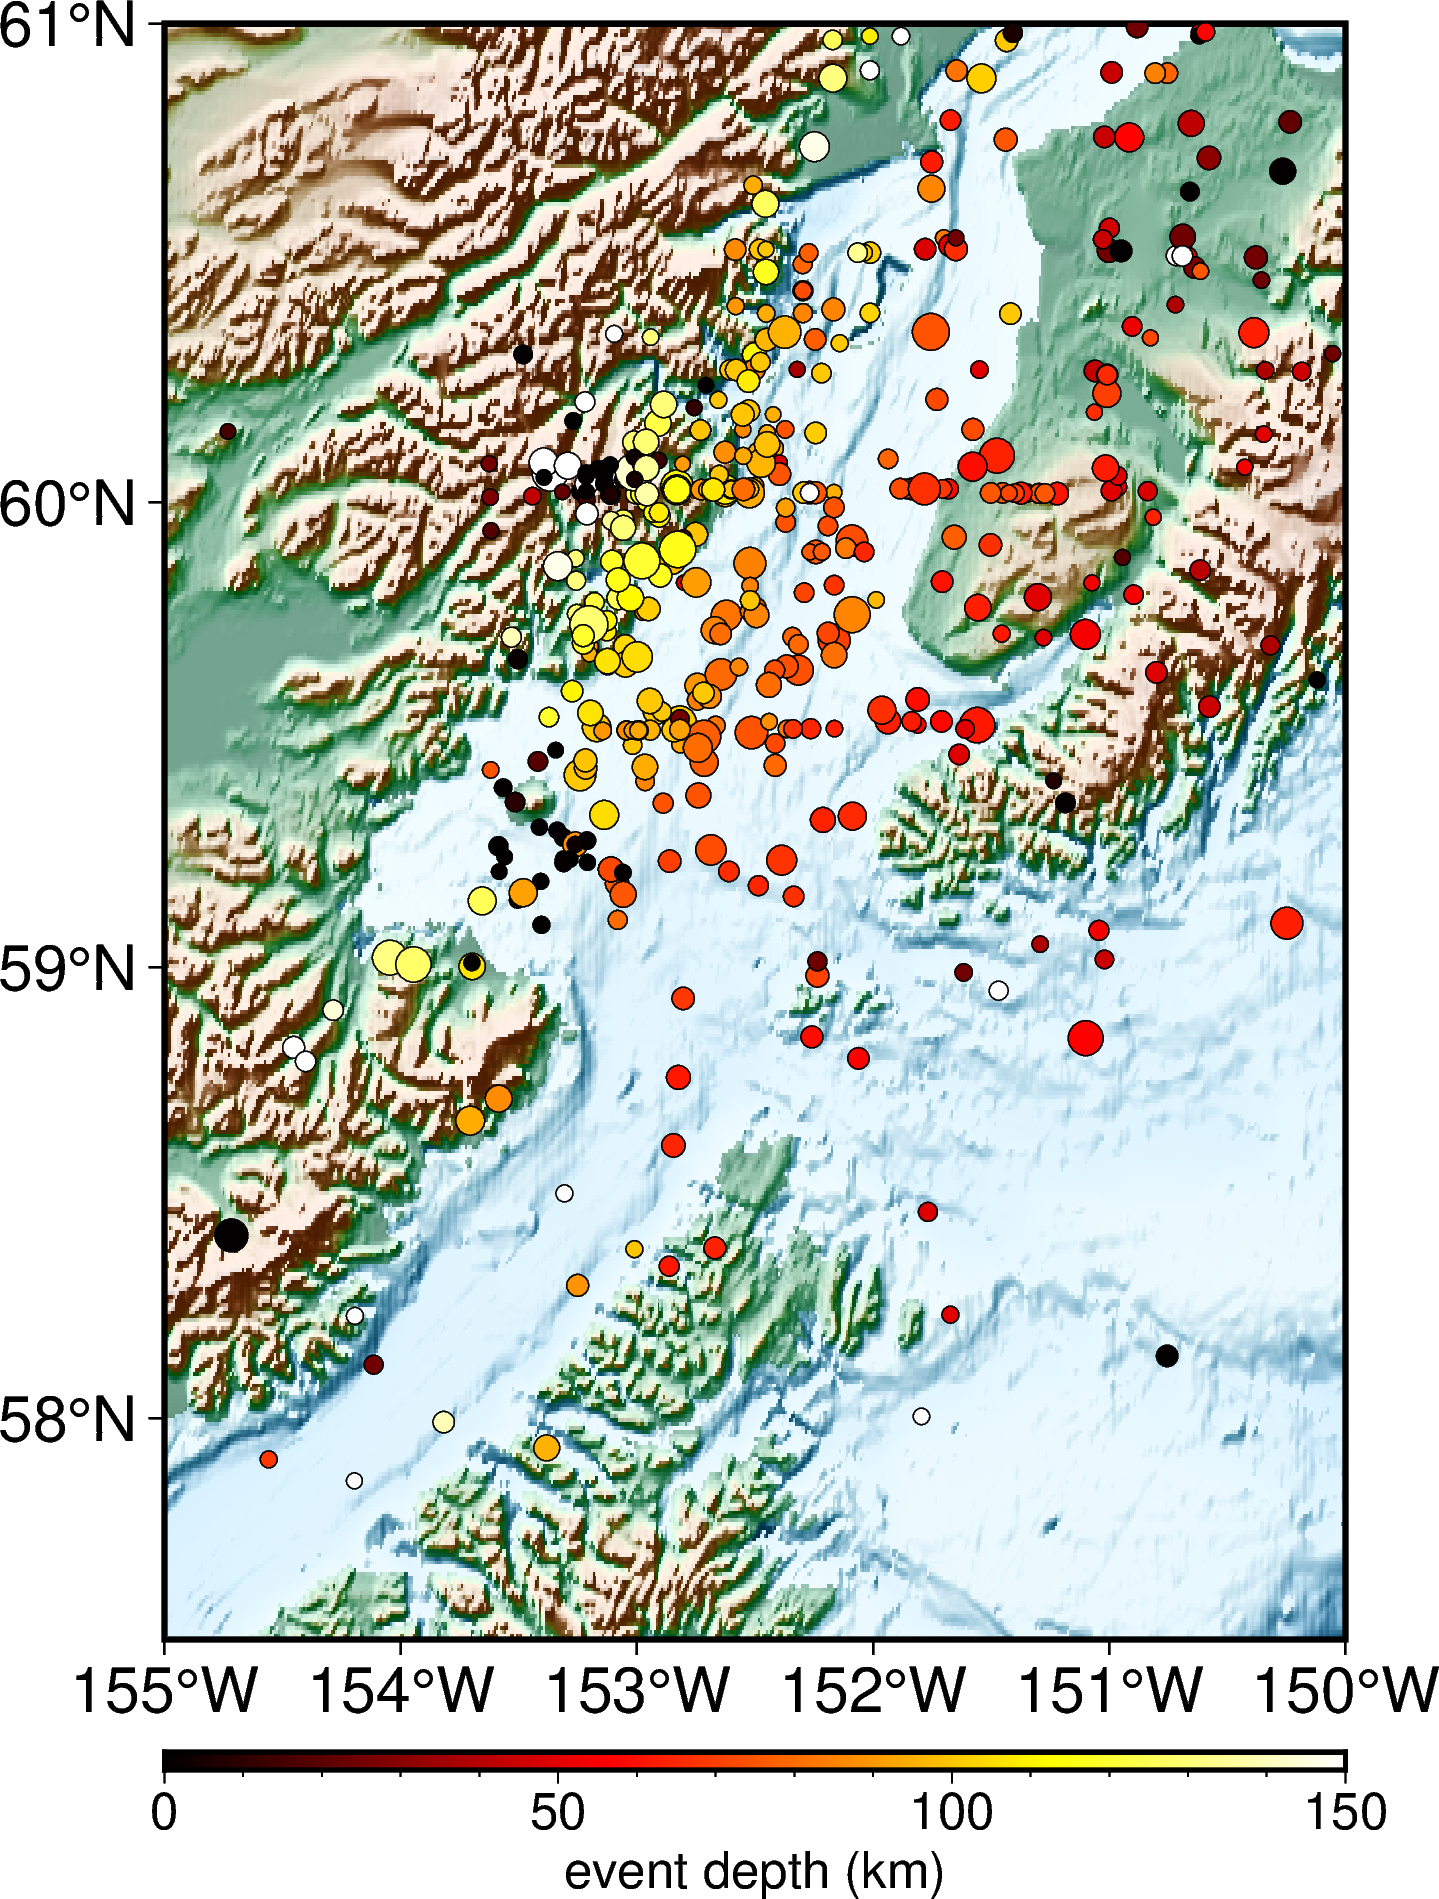

In [3]:
events = pd.read_csv(filepath + 'events_detect_octo.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments.csv')
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])

fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

## 4. Import DAS picks